# Sort out the installations
We need 3 libraries for this introduction to Quantization tutorial.
* Bits and Bytes
* Transformers
* Accelerate 

In [ ]:
!pip install -q bitsandbytes>=0.39.0
!pip install -q git+https://github.com/huggingface/accelerate.git
!pip install -q git+https://github.com/huggingface/transformers.git

# for visualizing weights 
!pip install -U matplotlib

# for implementing quant methods 
!pip install -U numpy

In [2]:
import torch
# from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers import T5Tokenizer, T5ForConditionalGeneration

# Set device to CPU for now
device = 'cuda:0'

# Load model and tokenizer
# model_name = "google/gemma-2b"
model_name = "google/flan-t5-small"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

# get the model size to compare 
print(f"Model size: {model.get_memory_footprint():,} bytes")


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Model size: 307,844,608 bytes


# Visualize the model architecture and some sample weights

In [3]:
# print the model architecture
model

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=384, bias=False)
              (k): Linear(in_features=512, out_features=384, bias=False)
              (v): Linear(in_features=512, out_features=384, bias=False)
              (o): Linear(in_features=384, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 6)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=512, out_features=1024, bias=False)
              (wi_1): Linear(in_features=512, out_features=1024, bias=False)
              (wo): 

In [4]:
# choose a self attention layer and check the weights
weights = model.decoder.block[0].layer[0].SelfAttention.q.weight.data
print("Original weights:")
print(weights)

Original weights:
tensor([[-0.0316,  0.0092, -0.0255,  ...,  0.0726, -0.0743,  0.0248],
        [-0.1088,  0.0024,  0.1102,  ...,  0.0702,  0.0320, -0.0037],
        [-0.0230, -0.0305,  0.0025,  ...,  0.0196,  0.0333,  0.1948],
        ...,
        [-0.1560,  0.0096, -0.0963,  ...,  0.0430,  0.1022,  0.0862],
        [-0.0767, -0.0164, -0.1109,  ..., -0.0115, -0.0603, -0.0807],
        [-0.0468, -0.0603, -0.0261,  ..., -0.0425, -0.0016,  0.0135]])


# Naive quantization Implementation
We will quantize our input float tensors into int8 tensors using Naive quantization methods below.
## Absolute Max Quantization
Absolute max is a symmetric quantization method. There are two steps involved:

    - divided by the absolute maximum value of the tensor
    - multiply with a scalar of 127
## Zero Point quantization
Zero Point is an asymmetric quantization method useful when we use activations like ReLU which give outputs skewed towards the positive side (0 to 1) and suppress outputs in the negative side.

    - normalize with differnce between max and min values
    - scale range to 255 
    - calulate zero point and shift distribution centered around zero-point

In [11]:
# absolute max quantization
def absmax_quantize(ip):
    # Calculate scale
    scale = 127 / torch.max(torch.abs(ip))
    # Quantize
    ip_quant = (scale * ip).round()
    # Dequantize
    ip_dequant = ip_quant / scale
    return ip_quant.to(torch.int8), ip_dequant


# zero point quantization 
def zeropoint_quantize(ip):
    # Calculate scale
    ip_range = torch.max(ip) - torch.min(ip)
    ip_range = 1 if ip_range == 0 else ip_range
    scale = 255 / ip_range
    # calculate zeropoint 
    zeropoint = (-scale * torch.min(ip) - 128).round()
    # quantize by rounding
    ip_quant = torch.clip((ip * scale + zeropoint).round(), -128, 127)
    # dequantize
    ip_dequant = (ip_quant - zeropoint) / scale
    return ip_quant.to(torch.int8), ip_dequant


In [12]:
# check absmax_quantize works
abs_weights_quant, _ = absmax_quantize(weights)
print("Absmax quantized weights:")
print(abs_weights_quant)

Absmax quantized weights:
tensor([[ -9,   3,  -7,  ...,  20, -20,   7],
        [-30,   1,  30,  ...,  19,   9,  -1],
        [ -6,  -8,   1,  ...,   5,   9,  53],
        ...,
        [-43,   3, -26,  ...,  12,  28,  24],
        [-21,  -4, -30,  ...,  -3, -17, -22],
        [-13, -17,  -7,  ..., -12,   0,   4]], dtype=torch.int8)


In [13]:
# check zeropoint_quantize works 
zp_weights_quant, _ = zeropoint_quantize(weights)
print("Zero-point quantized weights:")
print(zp_weights_quant)

Zero-point quantized weights:
tensor([[ 14,  27,  16,  ...,  48,   0,  32],
        [-12,  25,  60,  ...,  47,  34,  23],
        [ 16,  14,  25,  ...,  30,  35,  88],
        ...,
        [-27,  27,  -8,  ...,  38,  57,  52],
        [ -1,  19, -12,  ...,  20,   4,  -2],
        [  9,   4,  15,  ...,  10,  23,  28]], dtype=torch.int8)


In [14]:
import numpy as np 
from copy import deepcopy

model = model.to("cuda:0")
weights = [param.data.clone() for param in model.parameters()]

abs_model = deepcopy(model)
zp_model = deepcopy(model)

weights_abs = list()
for param in abs_model.parameters():
    _, abs_dequantized = absmax_quantize(param.data)
    param.data = abs_dequantized
    weights_abs.append(abs_dequantized)

weights_zp = list()
for param in zp_model.parameters():
    _, zp_dequantized = absmax_quantize(param.data)
    param.data = zp_dequantized
    weights_zp.append(zp_dequantized)

In [15]:
# visualize the distribution of weights
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Flatten weight tensors
weights = np.concatenate([t.cpu().numpy().flatten() for t in weights])
abs_weights = np.concatenate([t.cpu().numpy().flatten() for t in weights_abs])
zp_weights = np.concatenate([t.cpu().numpy().flatten() for t in weights_zp])

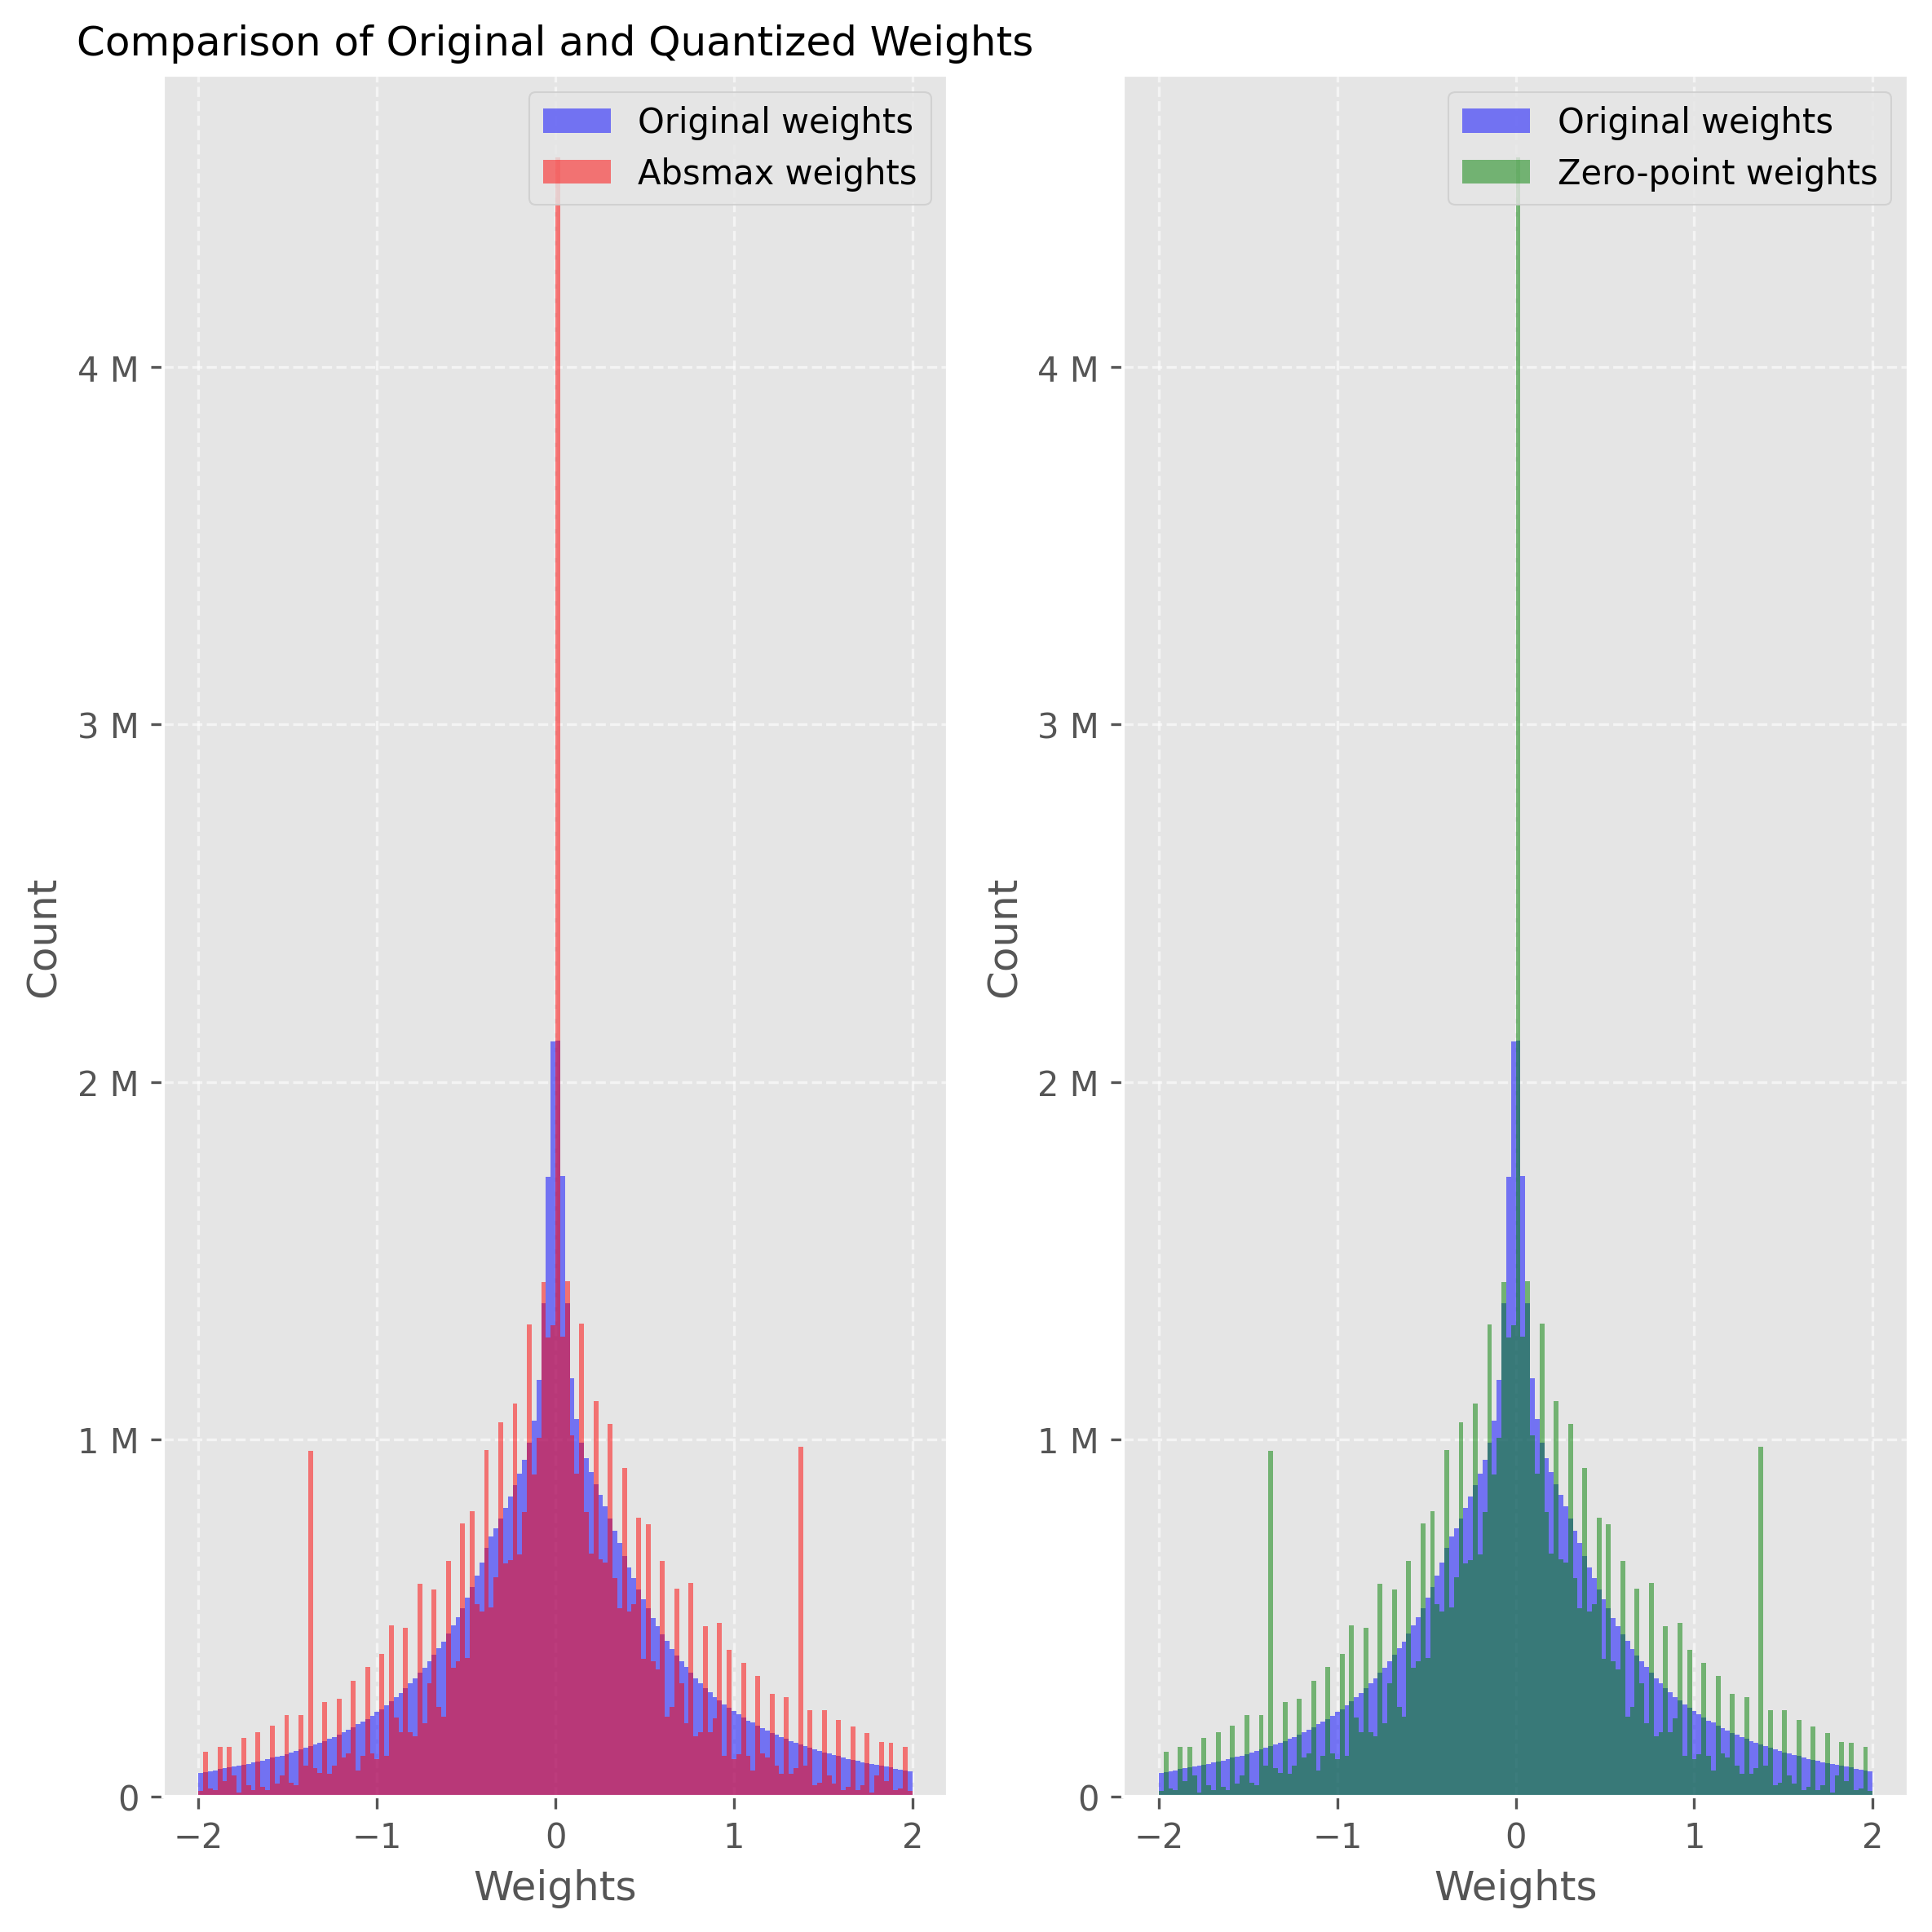

In [20]:
# Set background style
plt.style.use('ggplot')

# Create figure and axes
fig, axs = plt.subplots(1, 2, figsize=(8,8), dpi=300, sharex=True)

# Plot the histograms for original and zero-point weights
axs[0].hist(weights, bins=150, alpha=0.5, label='Original weights', color='blue', range=(-2, 2))
axs[0].hist(abs_weights, bins=150, alpha=0.5, label='Absmax weights', color='red', range=(-2, 2))

# Plot the histograms for original and absmax weights
axs[1].hist(weights, bins=150, alpha=0.5, label='Original weights', color='blue', range=(-2, 2))
axs[1].hist(zp_weights, bins=150, alpha=0.5, label='Zero-point weights', color='green', range=(-2, 2))

# Add grid
for ax in axs:
    ax.grid(True, linestyle='--', alpha=0.6)

# Add legend
axs[0].legend()
axs[1].legend()

# Add title and labels
axs[0].set_title('Comparison of Original and Quantized Weights', fontsize=12)
# axs[1].set_title('Comparison of Original and Zeropoint Quantized Weights', fontsize=16)

for ax in axs:
    ax.set_xlabel('Weights', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.yaxis.set_major_formatter(ticker.EngFormatter()) # Make y-ticks more human readable

# Improve font
plt.rc('font', size=10)
plt.tight_layout()
plt.show()


In [44]:
# Generate text with original and quantized models
# input_text = "translate from english to french:  \
#                 The primary use is research on language models, \
#                 including: research on zero-shot NLP tasks and in-context few-shot learning NLP tasks, such as reasoning, \
#                 and question answering; advancing fairness and safety research, and understanding limitations of current large language models"
input_text = "translate from english to french: how are you?"
input_ids = tokenizer(input_text, return_tensors="pt").input_ids.to("cuda")

model_outputs = model.generate(input_ids)
print(tokenizer.decode(model_outputs[0]))
print("=" * 50)

zp_model_op = zp_model.generate(input_ids)
print(tokenizer.decode(zp_model_op[0]))
print("=" * 50)

abs_model_op = abs_model.generate(input_ids)
print(tokenizer.decode(abs_model_op[0]))
print("=" * 50)

<pad>c'est-ce-t-t-t-t-t-t-
<pad> Comment je suis?</s>
<pad> Comment je suis?</s>


# Evaluate the 3 models

In [45]:
def calculate_perplexity(model, text):
    # Encode the text
    encodings = tokenizer(text, return_tensors='pt').to(device)
    # Define input_ids and target_ids
    input_ids = encodings.input_ids
    target_ids = input_ids.clone()
    with torch.no_grad():
        # loss, logits, past_key_values, decoder_hidden_states
        negative_log_likelihood = model(input_ids, labels=target_ids).loss
    # calculate perplexity
    perplexity = torch.exp(negative_log_likelihood)
    return perplexity


In [46]:
perplexity = calculate_perplexity(model, input_text)
absmax_perplexity = calculate_perplexity(abs_model, input_text)
zp_perplexity  = calculate_perplexity(zp_model, input_text)

print(f"Original perplexity: {perplexity.item():.2f}")
print(f"Absmax perplexity: {absmax_perplexity.item():.2f}")
print(f"Zeropoint perplexity: {zp_perplexity.item():.2f}")

Original perplexity: 7.07
Absmax perplexity: 7.80
Zeropoint perplexity: 7.80


tensor([[ 0.0011,  0.0049,  0.0069,  ...,  0.0016,  0.0079, -0.0010],
        [ 0.0029, -0.0085,  0.0335,  ...,  0.0245,  0.0120,  0.0035],
        [-0.0017, -0.0027, -0.0137,  ..., -0.0285, -0.0174,  0.0071],
        ...,
        [ 0.0003,  0.0003,  0.0107,  ...,  0.0219, -0.0055,  0.0020],
        [ 0.0032, -0.0019,  0.0254,  ...,  0.0340,  0.0137, -0.0047],
        [-0.0004, -0.0010,  0.0097,  ...,  0.0075,  0.0141,  0.0117]],
       device='cuda:0', dtype=torch.float16)


RuntimeError: "addmm_cuda" not implemented for 'Char'